# Lab 3: Extending Logistic Regression

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as SKLLogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from scipy.special import expit
from scipy.optimize import fmin_bfgs
from numpy.linalg import pinv
from numpy import ma
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
import copy
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
pd.set_option('display.max_columns', None)

# Business Understanding

The Bundesliga is the top professional soccer league in Germany. Just like many other major sports leagues, a significant amount of money is bet on games each season. According to [Statista](https://www.statista.com/statistics/1263462/value-betting-on-european-soccer/), 32.4 billion euros were bet on Bundesliga games in the 2020/21 season. Thus, it is very important for sports betters to be able to predict the outcomes of games. The prediction task for this dataset is to predict if the home team will win, lose, or draw a given Bundesliga match to help people who bet on games make more money off their bets. Rather than predicting the result for both teams in a game, we will create a model that predicts the result only for the home team in this notebook, as the away team's result is implied based on the home team's result. An accurate prediction algorithm has the potential to win a sports better a lot of money, but an inaccurate prediction algorithm could also lose a better a lot of money. As games are only played weekly, a model would only need to be trained once per week. This means that a prediction model would be mostly used for offline analysis. According to [Leans.ai](https://leans.ai/sports/sports-bets-must-win-to-profit/#:~:text=The%20percentage%20of%20sports%20bets,profit%20over%20the%20long%20term.), a better needs to win approximately 52.4% of the time to make a profit. Thus, a prediction algorithm needs to be correct a minimum of 52.4% of the time to be useful.

Dataset Link: https://www.kaggle.com/datasets/oles04/bundesliga-seasons

# Cleaning Data

In [2]:
df_init = pd.read_csv("../Datasets/bulidata.csv")

print(len(df_init))
df_init.head()

5508


,Unnamed: 0,MATCH_DATE,LEAGUE_NAME,SEASON,LEAGUE,FINISHED,LOCATION,VIEWER,MATCHDAY,MATCHDAY_NR,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_TEAM,HOME_ICON,AWAY_TEAM_ID,AWAY_TEAM_NAME,AWAY_TEAM,AWAY_ICON,GOALS_HOME,GOALS_AWAY,DRAW,WIN_HOME,WIN_AWAY
0,0,2005-08-05 20:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,München,NaN,1. Spieltag,1,40,FC Bayern München,Bayern,https://i.imgur.com/jJEsJrj.png,87,Borussia Mönchengladbach,Gladbach,https://i.imgur.com/KSIk0Eu.png,3,0,0.0,1.0,0.0
1,1,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Köln,NaN,1. Spieltag,1,65,1. FC Köln,Köln,https://upload.wikimedia.org/wikipedia/en/thum...,81,1. FSV Mainz 05,Mainz,https://upload.wikimedia.org/wikipedia/commons...,1,0,0.0,1.0,0.0
2,2,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Duisburg,NaN,1. Spieltag,1,107,MSV Duisburg,Duisburg,https://upload.wikimedia.org/wikipedia/en/c/c8...,16,VfB Stuttgart,Stuttgart,https://i.imgur.com/v0tkpNx.png,1,1,1.0,0.0,0.0
3,3,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Hamburg,NaN,1. Spieltag,1,100,Hamburger SV,HSV,https://upload.wikimedia.org/wikipedia/commons...,79,1. FC Nürnberg,Nürnberg,https://upload.wikimedia.org/wikipedia/commons...,3,0,0.0,1.0,0.0
4,4,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Wolfsburg,NaN,1. Spieltag,1,131,VfL Wolfsburg,Wolfsburg,https://i.imgur.com/ucqKV4B.png,7,Borussia Dortmund,BVB,https://upload.wikimedia.org/wikipedia/commons...,2,2,1.0,0.0,0.0


This dataset provides summary information about every Bundesliga game since the beginning of the 2005/06 season (5,508 games). The data as provided is not very useful for creating a prediction algorithm, so it will need to be restructured to suit our purposes. We can start by removing all of the unnecessary columns and renaming the remaining columns to more user-friendly names.

In [3]:
df_init = df_init.drop([
    "Unnamed: 0", "MATCH_DATE", "LEAGUE", "LEAGUE_NAME", "FINISHED", "LOCATION", "VIEWER", "MATCHDAY",
    "HOME_TEAM_NAME", "HOME_TEAM", "HOME_ICON", "AWAY_TEAM_NAME", "AWAY_TEAM", "AWAY_ICON"
], axis = 1).rename(columns = {
    "SEASON": "season",
    "MATCHDAY_NR": "matchday",
    "HOME_TEAM_ID": "home_team",
    "AWAY_TEAM_ID": "away_team",
    "GOALS_HOME": "home_goals",
    "GOALS_AWAY": "away_goals",
    "DRAW": "draw",
    "WIN_HOME": "home_win",
    "WIN_AWAY": "home_loss"
})
df_init[["home_team", "away_team"]] = df_init[["home_team", "away_team"]].astype(str)

df_init.head()

,season,matchday,home_team,away_team,home_goals,away_goals,draw,home_win,home_loss
0,2005,1,40,87,3,0,0.0,1.0,0.0
1,2005,1,65,81,1,0,0.0,1.0,0.0
2,2005,1,107,16,1,1,1.0,0.0,0.0
3,2005,1,100,79,3,0,0.0,1.0,0.0
4,2005,1,131,7,2,2,1.0,0.0,0.0


Since we want data on teams home and away, we can split the data into a data frame for the home teams and a data frame for the away teams. These data frames can be merged back together with more generic column names so that we now have 2 records for each game.

In [4]:
df_home = df_init.copy().rename(columns = {
    "home_team": "team",
    "away_team": "opponent",
    "home_goals": "scored",
    "away_goals": "conceded",
    "home_win": "win",
    "home_loss": "loss"
})
df_away = df_init.copy().rename(columns = {
    "home_team": "opponent",
    "away_team": "team",
    "home_goals": "conceded",
    "away_goals": "scored",
    "home_win": "loss",
    "home_loss": "win"
})
df_home["home"] = "1"
df_away["home"] = "0"
df_all = pd.concat([df_home, df_away])
df_all = df_all.sort_values(["season", "matchday"])

df_all

,season,matchday,team,opponent,scored,conceded,draw,win,loss,home
0,2005,1,40,87,3,0,0.0,1.0,0.0,1
1,2005,1,65,81,1,0,0.0,1.0,0.0,1
2,2005,1,107,16,1,1,1.0,0.0,0.0,1
3,2005,1,100,79,3,0,0.0,1.0,0.0,1
4,2005,1,131,7,2,2,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
5503,2022,34,40,65,2,1,0.0,1.0,0.0,0
5504,2022,34,9,1635,2,4,0.0,0.0,1.0,0
5505,2022,34,175,16,1,1,1.0,0.0,0.0,0
5506,2022,34,134,80,0,1,0.0,0.0,1.0,0


We can now calculate rolling sums of goals scored, goals conceded, wins, draws, and losses for each team in each season. Most soccer leagues use the last 5 games to represent a team's current form, so we will use 5 game rolling sums. This means that we will no longer have useable data on the first 5 games of each season, but there are not many useful predictors in this dataset anyway and we have a large number of records, so this is an acceptable loss. We can also calculate the points a team got from a game (3 points for a win, 1 point for a draw, and 0 points for a loss) and how many points each team has gotten that season prior to a given game. Finally, we can calculate the same values for a team's upcoming opponents over the last 5 games and the difference between the teams' seasonal points totals.

In [5]:
df_all["scored_5"] = df_all.groupby(["season", "team"])["scored"].transform(lambda x: x.rolling(5).sum().shift())
df_all["conceded_5"] = df_all.groupby(["season", "team"])["conceded"].transform(lambda x: x.rolling(5).sum().shift())
df_all["win_5"] = df_all.groupby(["season", "team"])["win"].transform(lambda x: x.rolling(5).sum().shift())
df_all["draw_5"] = df_all.groupby(["season", "team"])["draw"].transform(lambda x: x.rolling(5).sum().shift())
df_all["loss_5"] = df_all.groupby(["season", "team"])["loss"].transform(lambda x: x.rolling(5).sum().shift())
df_all["game_pts"] = df_all["win"] * 3 + df_all["draw"]
df_all["pts"] = df_all.groupby(["season", "team"])["game_pts"].cumsum().sub(df_all["game_pts"])

df_all["opp_scored_5"] = df_all.groupby(["season", "opponent"])["scored"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_conceded_5"] = df_all.groupby(["season", "opponent"])["conceded"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_win_5"] = df_all.groupby(["season", "opponent"])["win"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_draw_5"] = df_all.groupby(["season", "opponent"])["draw"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_loss_5"] = df_all.groupby(["season", "opponent"])["loss"].transform(lambda x: x.rolling(5).sum().shift())
df_all["opp_game_pts"] = df_all["loss"] * 3 + df_all["draw"]
df_all["opp_pts"] = df_all.groupby(["season", "team"])["opp_game_pts"].cumsum().sub(df_all["opp_game_pts"])
df_all["pts_diff"] = df_all["pts"] - df_all["opp_pts"]

df_all

,season,matchday,team,opponent,scored,conceded,draw,win,loss,home,scored_5,conceded_5,win_5,draw_5,loss_5,game_pts,pts,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,opp_game_pts,opp_pts,pts_diff
0,2005,1,40,87,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2005,1,65,81,1,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2005,1,107,16,1,1,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,2005,1,100,79,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,2005,1,131,7,2,2,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2022,34,40,65,2,1,0.0,1.0,0.0,0,12.0,7.0,3.0,0.0,2.0,3.0,68.0,6.0,11.0,1.0,1.0,3.0,0.0,23.0,45.0
5504,2022,34,9,1635,2,4,0.0,0.0,1.0,0,7.0,15.0,2.0,1.0,2.0,0.0,31.0,4.0,7.0,1.0,0.0,4.0,3.0,58.0,-27.0
5505,2022,34,175,16,1,1,1.0,0.0,0.0,0,9.0,9.0,2.0,0.0,3.0,1.0,35.0,6.0,9.0,1.0,2.0,2.0,1.0,59.0,-24.0
5506,2022,34,134,80,0,1,0.0,0.0,1.0,0,8.0,9.0,1.0,1.0,3.0,0.0,36.0,7.0,7.0,2.0,1.0,2.0,3.0,57.0,-21.0


The original dataset has one-hot encoded the result of the game, but we want a single column with the result.

In [6]:
results = []
for row in df_all.itertuples():
    if row.draw == 1:
        results.append("Draw")
    elif row.win == 1:
        results.append("Win")
    else:
        results.append("Loss")
df_all["result"] = results

df_all

,season,matchday,team,opponent,scored,conceded,draw,win,loss,home,scored_5,conceded_5,win_5,draw_5,loss_5,game_pts,pts,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,opp_game_pts,opp_pts,pts_diff,result
0,2005,1,40,87,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Win
1,2005,1,65,81,1,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Win
2,2005,1,107,16,1,1,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,Draw
3,2005,1,100,79,3,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Win
4,2005,1,131,7,2,2,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,Draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2022,34,40,65,2,1,0.0,1.0,0.0,0,12.0,7.0,3.0,0.0,2.0,3.0,68.0,6.0,11.0,1.0,1.0,3.0,0.0,23.0,45.0,Win
5504,2022,34,9,1635,2,4,0.0,0.0,1.0,0,7.0,15.0,2.0,1.0,2.0,0.0,31.0,4.0,7.0,1.0,0.0,4.0,3.0,58.0,-27.0,Loss
5505,2022,34,175,16,1,1,1.0,0.0,0.0,0,9.0,9.0,2.0,0.0,3.0,1.0,35.0,6.0,9.0,1.0,2.0,2.0,1.0,59.0,-24.0,Draw
5506,2022,34,134,80,0,1,0.0,0.0,1.0,0,8.0,9.0,1.0,1.0,3.0,0.0,36.0,7.0,7.0,2.0,1.0,2.0,3.0,57.0,-21.0,Loss


Now that we have calculated all of the statistics we want for our prediction model, we can remove all columns that are not going to be used in the model, filter the data for only home games that we will use for prediction, and convert all columns but the result to integers.

In [7]:
df = df_all[df_all["home"] == "1"].dropna().reset_index(drop = True).drop([
    "season", "matchday", "team", "opponent", "scored", "conceded", "draw", "win", "loss", 
    "home", "game_pts", "pts", "opp_game_pts", "opp_pts"
], axis = 1)
df.loc[:, df.columns != "result"] = df.loc[:, df.columns != "result"].astype(int)

df

,scored_5,conceded_5,win_5,draw_5,loss_5,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,pts_diff,result
0,5,8,1,2,2,6,16,0,1,4,-3,Win
1,8,9,1,2,2,8,5,2,2,1,-3,Win
2,3,9,1,1,3,3,14,0,0,5,-6,Loss
3,6,5,1,3,1,8,6,1,3,1,0,Loss
4,11,10,2,1,2,8,9,2,0,3,0,Win
...,...,...,...,...,...,...,...,...,...,...,...,...
4693,11,6,3,1,1,7,12,2,0,3,-3,Loss
4694,7,4,4,0,1,15,7,2,1,2,33,Win
4695,9,6,2,2,1,9,9,3,0,2,-24,Draw
4696,7,7,2,1,2,9,8,3,1,1,27,Win


Before using this data for modeling, we will normalize the numeric features using the Scikit-Learn's StandardScaler.

In [8]:
scaler = StandardScaler()

df.loc[:, df.columns != "result"] = scaler.fit_transform(df.loc[:, df.columns != "result"])
X = df.loc[:, df.columns != "result"].to_numpy()
y = df["result"].to_numpy()

# Data Understanding

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   scored_5        4698 non-null   float64
 1   conceded_5      4698 non-null   float64
 2   win_5           4698 non-null   float64
 3   draw_5          4698 non-null   float64
 4   loss_5          4698 non-null   float64
 5   opp_scored_5    4698 non-null   float64
 6   opp_conceded_5  4698 non-null   float64
 7   opp_win_5       4698 non-null   float64
 8   opp_draw_5      4698 non-null   float64
 9   opp_loss_5      4698 non-null   float64
 10  pts_diff        4698 non-null   float64
 11  result          4698 non-null   object 
dtypes: float64(11), object(1)
memory usage: 440.6+ KB


Only keeping the records for the home team and dropping the first 5 records for each season results in a total of 4,698 games to train our model with. There are no missing values in this dataset. All columns are numeric except for the result.

In [10]:
# Allow text to wrap to avoid cutting off descriptions
pd.set_option('display.max_colwidth', 0)

# Create data frame with feature descriptions
pd.DataFrame({
    "Feature": df.columns,
    "Description": [
        "How many goals the home team has scored over their last 5 games",
        "How many goals the home team has conceded over their last 5 games",
        "How many games the home team has won over their last 5 games",
        "How many games the home team has drawn over their last 5 games",
        "How many games the home team has lost over their last 5 games",
        "How many goals the away team has scored over their last 5 games",
        "How many goals the away team has conceded over their last 5 games",
        "How many games the away team has won over their last 5 games",
        "How many games the away team has drawn over their last 5 games",
        "How many games the away team has lost over their last 5 games",
        "The difference in total points this season for the 2 teams",
        "The result of the game for the home team"
    ],
    "Scale": [
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Ratio",
        "Interval",
        "Ordinal"
    ],
    "Discrete/Continuous": [
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete"
    ],
    "Range": [
        "{} - {}".format(min(df["scored_5"]), max(df["scored_5"])),
        "{} - {}".format(min(df["conceded_5"]), max(df["conceded_5"])),
        "{} - {}".format(min(df["win_5"]), max(df["win_5"])),
        "{} - {}".format(min(df["draw_5"]), max(df["draw_5"])),
        "{} - {}".format(min(df["loss_5"]), max(df["loss_5"])),
        "{} - {}".format(min(df["opp_scored_5"]), max(df["opp_scored_5"])),
        "{} - {}".format(min(df["opp_conceded_5"]), max(df["opp_conceded_5"])),
        "{} - {}".format(min(df["opp_win_5"]), max(df["opp_win_5"])),
        "{} - {}".format(min(df["opp_draw_5"]), max(df["opp_draw_5"])),
        "{} - {}".format(min(df["opp_loss_5"]), max(df["opp_loss_5"])),
        "{} - {}".format(min(df["pts_diff"]), max(df["pts_diff"])),
        repr(set(df["result"]))
    ]
})

,Feature,Description,Scale,Discrete/Continuous,Range
0,scored_5,How many goals the home team has scored over their last 5 games,Ratio,Discrete,-1.7274580838955738 - 5.48717643546774
1,conceded_5,How many goals the home team has conceded over their last 5 games,Ratio,Discrete,-1.86370804121856 - 4.749358709268445
2,win_5,How many games the home team has won over their last 5 games,Ratio,Discrete,-1.4701176989854166 - 2.815976970142973
3,draw_5,How many games the home team has drawn over their last 5 games,Ratio,Discrete,-1.376373399057795 - 3.3018223966110813
4,loss_5,How many games the home team has lost over their last 5 games,Ratio,Discrete,-1.5803766630393168 - 2.7757660047374433
5,opp_scored_5,How many goals the away team has scored over their last 5 games,Ratio,Discrete,-1.8328274757354786 - 3.972155887962506
6,opp_conceded_5,How many goals the away team has conceded over their last 5 games,Ratio,Discrete,-1.7326438754842854 - 4.681385427389364
7,opp_win_5,How many games the away team has won over their last 5 games,Ratio,Discrete,-1.5047913786174407 - 2.874241015302738
8,opp_draw_5,How many games the away team has drawn over their last 5 games,Ratio,Discrete,-1.3645539153851545 - 3.2936892865327763
9,opp_loss_5,How many games the away team has lost over their last 5 games,Ratio,Discrete,-1.5187013219149237 - 2.660084440271038


In [11]:
df.describe()

,scored_5,conceded_5,win_5,draw_5,loss_5,opp_scored_5,opp_conceded_5,opp_win_5,opp_draw_5,opp_loss_5,pts_diff
count,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03,4.698000e+03
mean,2.419899e-17,-9.679595e-17,2.419899e-17,-1.209949e-16,-8.469645e-17,-7.259696e-17,-1.209949e-16,2.419899e-17,7.259696e-17,-6.049747e-17,1.134327e-18
std,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00
min,-1.727458e+00,-1.863708e+00,-1.470118e+00,-1.376373e+00,-1.580377e+00,-1.832827e+00,-1.732644e+00,-1.504791e+00,-1.364554e+00,-1.518701e+00,-3.740594e+00
25%,-8.617019e-01,-6.613323e-01,-6.128988e-01,-4.407342e-01,-7.091481e-01,-9.162512e-01,-6.171605e-01,-6.289849e-01,-4.329053e-01,-6.829442e-01,-6.993313e-01
50%,4.054201e-03,-6.014438e-02,2.443202e-01,-4.407342e-01,1.620804e-01,3.251654e-04,-5.941884e-02,2.468216e-01,-4.329053e-01,1.528130e-01,1.625998e-02
75%,5.812250e-01,5.410435e-01,2.443202e-01,4.949049e-01,1.033309e+00,6.113760e-01,4.983228e-01,2.468216e-01,4.987434e-01,9.885701e-01,5.529534e-01
max,5.487176e+00,4.749359e+00,2.815977e+00,3.301822e+00,2.775766e+00,3.972156e+00,4.681385e+00,2.874241e+00,3.293689e+00,2.660084e+00,4.667603e+00


The table above gives the summary statistics for all of our numeric features. The distributions of the goals scored and conceded for both teams are all very similar. The distributions of the wins, draws, and losses for both teams are also very similar to each other. Based on the mean and median of the points difference being almost the same, it can be inferred that the distribution of the points differences is approximately symmetric. This means that teams are on average playing similar numbers of teams that are better than them and worse than them that season.

In [12]:
result_counts = pd.Series.value_counts(df["result"])

display(result_counts)
result_counts / len(df)

Win     2010
Draw    1351
Loss    1337
Name: result, dtype: int64

Win     0.427842
Draw    0.287569
Loss    0.284589
Name: result, dtype: float64

There is a slight class imbalance here, as 42.8% of games result in a win for the home team, 28.8% result in a draw, and 28.5% result in a loss for the home team.

For this dataset, a random 80/20 training/testing split is probably not the best way of evaluating model performance. Instead, the games should be split by season, with a set number of seasons being used for training and the rest for testing. Specifically, the more recent seasons should be used for testing. This would simulate using the model to predict results in an upcoming season based on past seasons, which is what a deployed model would be doing. However, for this lab, we will use a random 80/20 training/testing split with 10 repeats.

In [13]:
cv_object = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 7324)

# Modeling

## Logistic Regression Implementation

To create a multiclass logistic regression function, we first need to create our binary logistic regression (BLR) solvers. Each BLR implementation will take the learning rate (eta), the number of iterations, the regularization method, the mixture (explained later), and the regularization penalty term (C) as parameters. The 4 regularization options are no regularization, L1 regularization (Lasso), L2 regularization (Ridge), or both L1 and L2 regularization. When the regularization is set to both, my implementation will use the [glmnet](https://glmnet.stanford.edu/articles/glmnet.html) implementation of Elastic Net. This implementation of Elastic Net uses a combination of L1 and L2 regression based on the mixture parameter, a floating-point number in the range $0 \leq mixture \le 1$. The mixture term represent the proportion of regularization that is L1. A mixture of 0 is the same as L2 regularization, a mixture of 1 is the same as L1 regularization, and anything in between will scale each regularization term based on its proportion. The mixutre term will not be used unless the regularization method is set to both.

### Steepest Ascent

The first BLR implementation is steepest ascent. Steepest ascent takes the gradient of the objective function at each iteration and updates the weights using the learning rate and the gradient. The gradient determines which direction each weight needs to move in to maximize the objective function. In this case, the objective function is log likelihood. The code for each BLR implemenation is mostly from Dr Larson's notebook, but it has been updated to accept any of the regularization methods.

In [14]:
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, regularization = "none", mixture = 0.5, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg = regularization
        self.mix = mixture
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return gradient
    
    # Calculate the L1 term (lasso)
    def _get_L1(self, weights = True):
        if weights:
            return self.C * np.sign(self.w_[1:])
        else:
            return self.C
    
    # Calculate the L2 term (ridge)
    def _get_L2(self, weights):
        if weights:
            return -2 * self.w_[1:] * self.C
        else:
            return -2 * self.C
    
    # Get the regularization (if any)
    def _get_regularization(self, weights = True):
        if self.reg == "l1":
            return self._get_L1(weights = weights)
        elif self.reg == "l2":
            return self._get_L2(weights = weights)
        elif self.reg == "both":
            return (((1 - self.mix) * self._get_L2(weights = weights)) + (self.mix * self._get_L1(weights = weights)))
        else:
            return 0
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
       
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

### Stochastic Gradient Ascent

The second BLR implementation is stochastic gradient ascent (SGA). SGA speeds up the gradient calculation by approximating the gradient using only one observation. As a result, the weight updates may not be as direct towards the maximum objective function as steepest ascent. This means that SGA may need more iterations to reach the optimal weights.

In [15]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return gradient

### Newton's Method

The third and final BLR implementation is using Newton's method. Newton's method uses the inverse of the Hessian matrix in addition to the learning rate and the gradient of the objective function to update the weights. The Hessian matrix is symmetric along the diagonal and is composed of the pairwise products of the gradient at each value in the weight vector. The problem with Newton's method is that it can be slow to calculate the inverse of the Hessian matrix.

In [16]:
class HessianLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X # calculate the hessian
        hessian += self._get_regularization(weights = False)
        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return pinv(hessian) @ gradient

### Multiclass Model

Now that we have all 3 BLR implementations, we can combine them into one multiclass logistic regression function. To classify with multiple classes, separate BLR models are fit for each class, and the class with the largest predicted probability is the model's classification. The parameters are the same as the BLR implementations, but there is now a solver parameter for which BLR implementation to use.

In [17]:
class MyLogisticRegression:
    def __init__(self, eta, iterations=20, solver="steepest", regularization="none", mixture=0.5, C=0.001):
        # Make sure that the parameter values are valid
        assert solver in ["steepest", "stochastic", "newton"], "Invalid solver input"
        assert regularization in ["none", "l1", "l2", "both"], "Invalid regularization input"
        assert mixture >= 0 and mixture <= 1, "Invalid mixture"
        
        self.eta = eta
        self.iters = iterations
        self.opt = solver
        self.reg = regularization
        self.mix = mixture
        self.C = C
        
    def __str__(self):
        if(hasattr(self,'w_')):
            # is we have trained the object
            return 'Multiclass Logistic Regression Object with {} solver and {} regularization and coefficients:\n'.format(self.opt, self.reg) + str(self.w_) 
        else:
            return 'Untrained Multiclass Logistic Regression Object with {} solver and {} regularization'.format(self.opt, self.reg)
     
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        # Parameters to pass into binary classifier
        params = {
            "eta": self.eta,
            "iterations": self.iters,
            "regularization": self.reg,
            "mixture": self.mix,
            "C": self.C
        }
        # Set solver based on specified optimization method
        if self.opt == "steepest":
            self.solver = BinaryLogisticRegression
        elif self.opt == "stochastic":
            self.solver = StochasticLogisticRegression
        else:
            self.solver = HessianLogisticRegression
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = self.solver(**params)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    # Set specified hyperparameters after tuning (or manually)
    def set_hyperparameters(self, params):
        # Set parameters with defined hyperparameters
        if params["solver"] != None:
            assert params["solver"] in ["steepest", "stochastic", "newton"], "Invalid solver input"
            self.opt = params["solver"]
        
        if params["regularization"] != None:
            assert params["regularization"] in ["none", "l1", "l2", "both"], "Invalid regularization input"
            self.reg = params["regularization"]
            
        if params["mixture"] != None:
            assert params["mixture"] >= 0 and params["mixture"] <= 1, "Invalid mixture"
            self.mix = params["mixture"]
            
        if params["penalty"] != None:
            self.C = params["penalty"]

## Model Fitting

### My Implementation

How do we know which parameters to use to get the best model fit? We need to tune these parameters to our data to find the best combination. These tunable parameters are often referred to as hyperparameters. The function below will create a grid of a specified size with random values for each hyperparameter. We can tune our model using this grid to determine which of the random combinations works the best. This grid function uses the solver, regularization method, mixture, and C as the hyperparameters. If a specific value is wanted for one of these hyperparameters, that value can be passed into the function and that hyperparameter will not be randomized.

In [18]:
# Create a hyperparameter grid for solver, regularization, mixture, and C
def create_grid(
    combinations=100, seed = None, 
    solver = None, regularization = None, mixture = None, C = None
):
    # Set random seed if defined
    if seed != None:
        random.seed(seed)

    # Create data frame for grid
    grid = pd.DataFrame()

    # Create ranges of values
    opt = ["steepest", "stochastic", "newton"]
    reg = ["none", "l1", "l2", "both"]
    mix = np.linspace(0, 1, 1000)
    pen = np.logspace(-5, 1, 20)

    # Randomly sample values
    if solver == None:
        grid["solver"] = random.choices(opt, k = combinations)
    else:
        grid["solver"] = [solver] * combinations

    if regularization == None:
        grid["regularization"] = random.choices(reg, k = combinations)
    else:
        grid["regularization"] = [regularization] * combinations

    if mixture == None:
        grid["mixture"] = random.choices(mix, k = combinations)
    else:
        grid["mixture"] = [mixture] * combinations

    if C == None:
        grid["penalty"] = random.choices(pen, k = combinations)
    else:
        grid["penalty"] = [C] * combinations

    return grid

The function below will take a grid of hyperparameters, a cross validation object, and the full data set to tune the hyperparameters. A model is fit using each cross validation sample of the data for each hyperparameter combination in the grid. The average accuracy and runtime for each combination is stored in a new grid. The grid is then returned, sorted by accuracy and runtime. The hyperparameter combination with the best accuracy, and best time if there is a tie, is chosen is the optimal hyperparameter combination.

In [19]:
# Tune a grid of hyperparameters
def tune(X, y, cv_object, grid, params, LogisticClass = MyLogisticRegression):
    # Create a deep copy of the grid so that the original is not modified
    grid = copy.deepcopy(grid)
    # Lists to store accuracy and time of each combination
    acc = []
    times = []
    # Iterate through each combination in the grid
    for row in grid.itertuples():
        curr_acc = []
        curr_times = []
        # Iterate through each train/test split in cv_object
        for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
            # Extract hyperparameters
            params["solver"] = row.solver
            params["regularization"] = row.regularization
            params["mixture"] = row.mixture
            params["C"] = row.penalty

            # Fit model with these hyperparameters and calculate the accuracy
            model = LogisticClass(**params)
            start = time.time()
            model.fit(X[train_indices], y[train_indices])
            curr_times.append(time.time() - start)
            yhat = model.predict(X[test_indices])
            curr_acc.append(accuracy_score(y[test_indices], yhat))
            
        # Add the mean accuracy and time from all of the train/test splits to acc
        acc.append(np.mean(curr_acc))
        times.append(np.mean(curr_times))

    # Add accuracy and time column to grid
    grid["accuracy"] = acc
    grid["time"] = times
    # Sort grid by accuracy
    grid = grid.sort_values(["accuracy", "time"], ascending = [False, True])
    # Return grid
    return grid

This method of tuning the hyperparameters is justified, because should result in as little bias as possible. There is no data snooping involved, as there is no human influence on the outcome of the tuning. The most accurate combination is chosen automatically. The main things that could result in some bias are the possible numeric values selected by linspace or logspace and the random variation of the parameter combinations. It is possible that the optimal value of C is between two of the tested values. We can reduce this risk by increasing the number of possible values, but it is impossible to eliminate this risk. Additionally, add more possible values means that more combinations need to be tested to check all combinations, which can be very slow. It is also possible that the random combinations added to the grid do not include the optimal combination of possible values. This risk can be reduced by increasing the number of comibations, but as previously mentioned that can be slow. The number of possible values and combinations used in this implementation should be good enough to get reasonably close the the optimal hyperparameter combination.

Using the previously defined function, we can generate a grid of 200 random hyperparameter combinations.

In [20]:
grid_init = create_grid(200, seed = 7324)
grid_init

,solver,regularization,mixture,penalty
0,newton,both,0.163163,0.000183
1,stochastic,both,0.374374,0.014384
2,newton,l2,0.188188,0.000089
3,steepest,both,0.259259,0.000021
4,newton,l2,0.063063,0.014384
...,...,...,...,...
195,newton,none,0.832833,0.000089
196,newton,none,0.492492,0.263665
197,steepest,both,0.210210,0.029764
198,stochastic,l2,0.000000,0.029764


We can now tune this grid using our data. The learning rate and number of iterations are not being tuned here, so they are manually set.

In [21]:
%%time

params = {
    "eta": 0.1,
    "iterations": 20
}

grid_acc = tune(X, y, cv_object, grid_init, params)
grid_acc

CPU times: user 2h 47min 29s, sys: 47min 14s, total: 3h 34min 44s
Wall time: 19min 41s


,solver,regularization,mixture,penalty,accuracy,time
146,newton,both,0.798799,4.832930,0.458617,1.123093
174,newton,both,0.342342,4.832930,0.458191,1.153672
49,newton,both,0.829830,1.128838,0.457553,2.282905
7,newton,both,0.820821,1.128838,0.457553,2.580524
37,newton,both,0.430430,1.128838,0.457340,1.292745
...,...,...,...,...,...,...
31,stochastic,l1,0.607608,4.832930,0.336064,0.002041
48,stochastic,both,0.826827,0.545559,0.335532,0.002884
168,stochastic,both,0.886887,4.832930,0.327660,0.001904
38,stochastic,l1,0.948949,4.832930,0.321596,0.001904


The result of the hyperparameter tuning is that Newton's method, Elastic Net regularization, C a mixture of 0.8, and C of 4.8 yielded the best accuracy (45.9%).

In [22]:
grid_acc.groupby(["solver", "regularization"])[["accuracy", "time"]].describe()

accuracy                                    \
                             count      mean           std       min   
solver     regularization                                              
newton     both            20.0     0.451319  2.580637e-02  0.341702   
           l1              13.0     0.456841  9.094153e-05  0.456809   
           l2              19.0     0.456680  2.849682e-04  0.455957   
           none            16.0     0.456809  1.146633e-16  0.456809   
steepest   both            21.0     0.445755  1.074915e-02  0.424149   
           l1              13.0     0.444124  1.214306e-02  0.424255   
           l2              13.0     0.451645  3.436664e-04  0.450745   
           none            18.0     0.451915  1.142410e-16  0.451915   
stochastic both            24.0     0.376015  2.042580e-02  0.327660   
           l1              14.0     0.362310  2.317709e-02  0.315957   
           l2              17.0     0.389287  1.150946e-02  0.360851   
           none            12.0     0.384619  1.308314e-02  0.362766   

                                                                   time  \
                                25%       50%       75%       max count   
solver     regularization                                                 
newton     both            0.456809  0.456809  0.457021  0.458617  20.0   
           l1              0.456809  0.456809  0.456809  0.457128  13.0   
           l2              0.456649  0.456809  0.456809  0.456915  19.0   
           none            0.456809  0.456809  0.456809  0.456809  16.0   
steepest   both            0.443830  0.451809  0.452128  0.453191  21.0   
           l1              0.437234  0.451809  0.452447  0.453085  13.0   
           l2              0.451489  0.451596  0.451915  0.452128  13.0   
           none            0.451915  0.451915  0.451915  0.451915  18.0   
stochastic both            0.365399  0.380053  0.389468  0.403936  24.0   
           l1              0.355559  0.366755  0.378963  0.390000  14.0   
           l2              0.381277  0.392128  0.396277  0.406064  17.0   
           none            0.377207  0.380745  0.395000  0.404468  12.0   

                                                                             \
                               mean       std       min       25%       50%   
solver     regularization                                                     
newton     both            1.674866  0.429850  1.123093  1.307926  1.561419   
           l1              1.791722  0.463640  1.161876  1.226675  1.923773   
           l2              1.734522  0.494865  1.116289  1.261200  1.743565   
           none            1.650540  0.505808  1.121558  1.159347  1.428192   
steepest   both            0.023649  0.013667  0.010583  0.011945  0.014299   
           l1              0.019013  0.010684  0.011042  0.011893  0.012654   
           l2              0.023110  0.017410  0.010636  0.011977  0.016146   
           none            0.023628  0.011393  0.010908  0.011897  0.023265   
stochastic both            0.002021  0.000389  0.001393  0.001739  0.002105   
           l1              0.001860  0.000347  0.001436  0.001623  0.001780   
           l2              0.001850  0.000390  0.001261  0.001565  0.001785   
           none            0.001770  0.000318  0.001201  0.001588  0.001751   

                                               
                                75%       max  
solver     regularization                      
newton     both            1.987010  2.580524  
           l1              2.186094  2.283172  
           l2              2.177874  2.526754  
           none            2.167103  2.361409  
steepest   both            0.038099  0.044732  
           l1              0.027526  0.039852  
           l2              0.026793  0.075318  
           none            0.032384  0.048438  
stochastic both            0.002264  0.002884  
           l1              0.002021  0.002811  
         

The table of shows the summary statistics for the accuracy and runtime for each solver and regularization method combination. The table shows that the solver has a more significant influence on the accuracy and runtime of a model than the regularization method. SGA has a much lower accuracy that the other methods on average. This is likely because the number of iterations was constant. If the initial number of iterations was higher, maybe the SGA models would have performed better. 

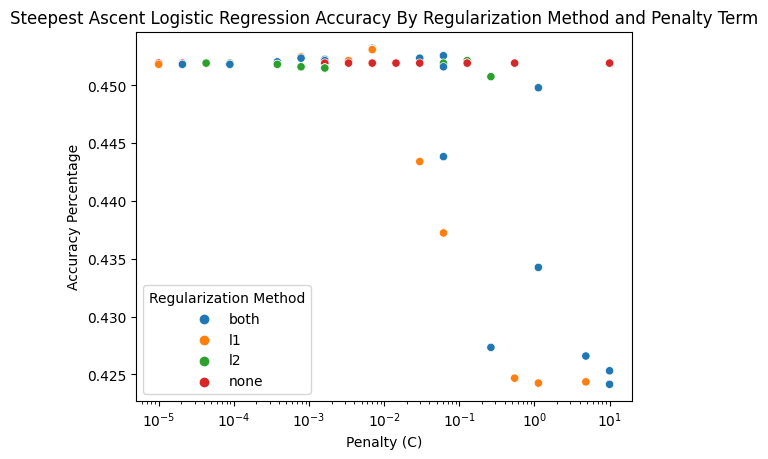

In [23]:
sns.scatterplot(
    data = grid_acc[grid_acc["solver"] == "steepest"], 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("Steepest Ascent Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

The scatter plot shows the relationship between the value of C, the regularization method, and the accuracy of each model using steepest ascent. As C increases, the accuracy of the models that use regularization tends to decrease.

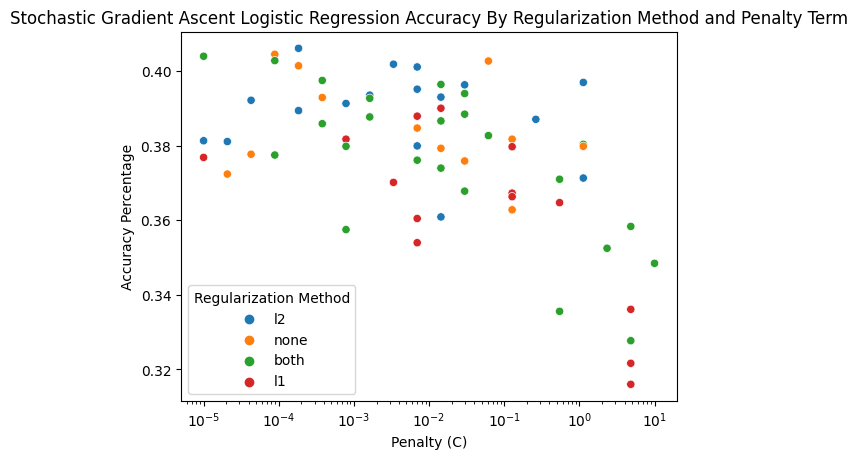

In [24]:
sns.scatterplot(
    data = grid_acc[grid_acc["solver"] == "stochastic"], 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("Stochastic Gradient Ascent Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

The scatter plot shows the relationship between the value of C, the regularization method, and the accuracy of each model using SGA. As C increases, the accuracy of the models tends to decrease. There is more variation in the accuracy of the SGA models than the steepest ascent models, particularly those without regularization. This is likely because the random observation selection in the gradient approximation is not seeded, so it is different for each model that is fit.

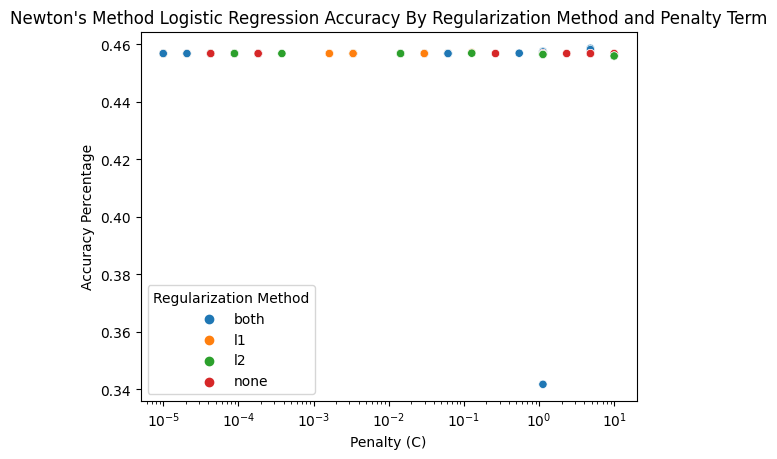

In [25]:
sns.scatterplot(
    data = grid_acc[grid_acc["solver"] == "newton"], 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("Newton's Method Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

The scatter plot shows the relationship between the value of C, the regularization method, and the accuracy of each model using Newton's method. The value of C and the regularization method do not appear to have a significant influence on the accuracy of a model. However, there is one outlier that has a much worse accuracy than the rest of the models.

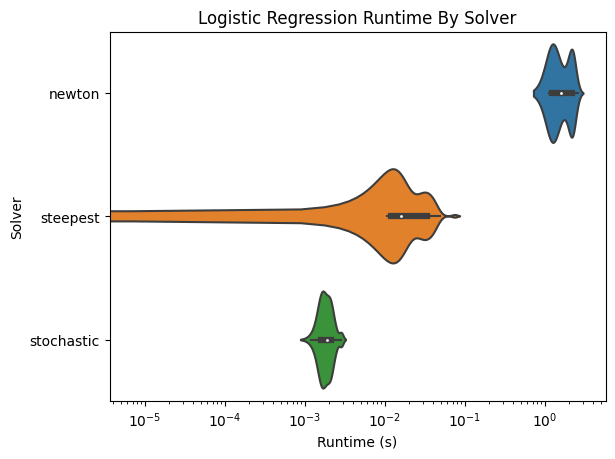

In [26]:
sns.violinplot(
    data = grid_acc,
    x = "time",
    y = "solver",
    scale = "count"
)

plt.title("Logistic Regression Runtime By Solver")
plt.xlabel("Runtime (s)")
plt.ylabel("Solver")
plt.xscale("log")

plt.show()

The violin plot shows the distribution of the runtime for each BLR solver. Newton's method is by far the slowest of the 3 solvers and SGA is the fastest on average.

In [27]:
# Convert the first row of the tuned hyperparameter grid (best combination) to a dictionary
hyperparams = grid_acc.to_dict("records")[0]

We can now rerun our model using the optimal hyperparameter combination on all of the cross validation samples to compare the fit of this model to Scikit-Learn's implementation.

In [28]:
%%time

my_acc = []
my_yhats = []
my_times = []
conf_mat = None
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    my_model = MyLogisticRegression(0.1)
    my_model.set_hyperparameters(hyperparams)
    start = time.time()
    my_model.fit(X[train_indices], y[train_indices])
    my_times.append(time.time() - start)
    yhat = my_model.predict(X[test_indices])
    my_yhats.append(yhat)
    my_acc.append(accuracy_score(y[test_indices], yhat))
    conf_mat = mt.confusion_matrix(y[test_indices], yhat)
print('Accuracy of: ', np.mean(my_acc))

Accuracy of:  0.4586170212765957
CPU times: user 3min 28s, sys: 55.3 s, total: 4min 24s
Wall time: 25.6 s


In [29]:
print(my_model)

conf_mat

Multiclass Logistic Regression Object with newton solver and both regularization and coefficients:
[[-0.81355861 -0.22122879  0.09975371  0.86098926  0.71997664  0.6006936
  -0.12754222 -0.11569775  0.74320606  0.68318505  0.75406431 -0.12824042]
 [-0.82247967 -0.13857434  0.0407694   0.71590242  0.64306649  0.68488447
  -0.24729222  0.42356474  0.79636152  0.63584732  0.6153226  -0.22822107]
 [-0.25914063  0.28662442 -0.09542834 -0.64742282 -0.53849986 -0.4394092
   0.33604401 -0.30813245 -0.66328182 -0.50479113 -0.46089681  0.30377148]]


array([[ 46,  58, 178],
       [ 33,  82, 144],
       [ 58,  52, 289]])

### Scikit-Learn Implementation

In [30]:
# Initialize Sc
skl_model = SKLLogisticRegression(solver='liblinear',n_jobs=1, 
                           multi_class='ovr', max_iter=100) 
print(skl_model)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')


We can run the same code using the Scikit-Learn implementation as we did for our implementation to determine which is a better fit for this data.

In [31]:
%%time

skl_acc = []
skl_yhats = []
skl_times = []
conf_mat = None
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    start = time.time()
    skl_model.fit(X[train_indices], y[train_indices])
    skl_times.append(time.time() - start)
    yhat = skl_model.predict(X[test_indices])
    skl_yhats.append(yhat)
    skl_acc.append(accuracy_score(y[test_indices], yhat))
    conf_mat = mt.confusion_matrix(y[test_indices], yhat)
print('Accuracy of: ', np.mean(skl_acc))

Accuracy of:  0.45787234042553193
CPU times: user 138 ms, sys: 298 ms, total: 436 ms
Wall time: 128 ms


In [32]:
print(skl_model.coef_)

conf_mat

[[-2.41461596e-01  9.65899627e-02  1.10502139e-01  3.96176522e-02
  -1.49198406e-01 -1.44558557e-01 -1.29495658e-01  1.53718781e-02
   2.82949074e-04 -1.49227711e-02 -1.45326495e-01]
 [-1.37693570e-01  2.51388297e-02 -1.01700636e-02  4.58911393e-04
   9.90895444e-03 -2.66882543e-01  4.81670856e-01  1.15479137e-01
  -7.29893927e-03 -1.03650764e-01 -2.68239147e-01]
 [ 3.04197655e-01 -8.85293644e-02 -8.07343056e-02 -3.11625886e-02
   1.11071068e-01  3.64243389e-01 -3.38318532e-01 -1.23370341e-01
   6.64719252e-03  1.11765779e-01  3.43281412e-01]]


array([[ 43,  59, 180],
       [ 33,  82, 144],
       [ 57,  52, 290]])

## Model Comparison

In [33]:
# Get all y values from cross validations
y_cv = []
for train, test in cv_object.split(X,y):
    for yi in y[test]:
        y_cv.append(yi)
# Flatten both sets of yhats
my_yhats = [yhat for yhats in my_yhats for yhat in yhats]
skl_yhats = [yhat for yhats in skl_yhats for yhat in yhats]
# Create data frame to calculate accuracies
df_y = pd.DataFrame({
    "y": y_cv,
    "Mine": my_yhats,
    "SKL": skl_yhats
}).groupby("y")
# Extract predictions for mine and SKL's im
my_pred = df_y["Mine"].value_counts()
skl_pred = df_y["SKL"].value_counts()
# Calculate accuracy for each model and each result
my_pred_accs = []
skl_pred_accs = []
for result in ["Win", "Draw", "Loss"]:
    my_pred_accs.append(my_pred[result, result] / sum(my_pred[result]))
    skl_pred_accs.append(skl_pred[result, result] / sum(skl_pred[result]))
# Add total accuracy for each model
my_pred_accs.append(np.mean(my_acc))
skl_pred_accs.append(np.mean(skl_acc))

# Create data frame with accuracies by result and model
df_cmp = pd.DataFrame({
    "Result": ["Win", "Draw", "Loss", "Overall"] * 2,
    "Model": ["Mine"] * 4 + ["SKL"] * 4,
    "Accuracy": my_pred_accs + skl_pred_accs
})
df_cmp

,Result,Model,Accuracy
0,Win,Mine,0.769136
1,Draw,Mine,0.155311
2,Loss,Mine,0.294656
3,Overall,Mine,0.458617
4,Win,SKL,0.771605
5,Draw,SKL,0.149817
6,Loss,SKL,0.293893
7,Overall,SKL,0.457872


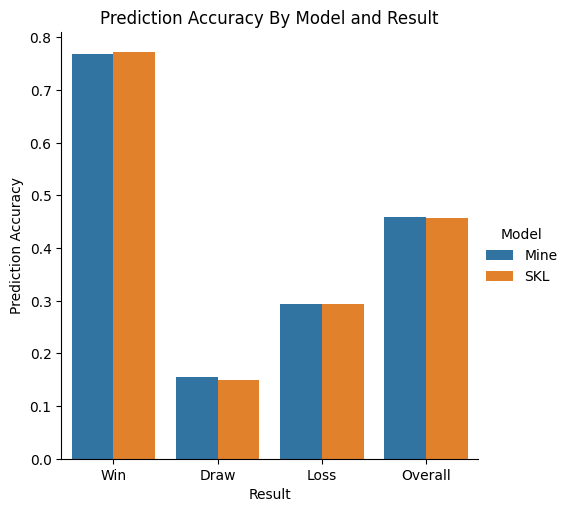

In [34]:
sns.catplot(
    data = df_cmp,
    kind = "bar",
    x = "Result",
    y = "Accuracy",
    hue = "Model"
)

plt.title("Prediction Accuracy By Model and Result")
plt.xlabel("Result")
plt.ylabel("Prediction Accuracy")

plt.show()

The bar chart and the table above show how accurate each model is at predicting wins, draws, and losses. Scikit-Learn's model is better at predicting wins, but my model is better at predicting draws and losses. However, both models perform very similarly and are much better at predicting wins than draws and losses. This is likely due to the class imbalance in the data. As a result, my model has a slightly higher overall accuracy. In the business understanding we stated that the desired accuracy is 52.4%, but neither model reaches that accuracy. This means that our features are not good enough to make useful predictions on this data set.

In [35]:
# Create data frame for timing data
df_time = pd.DataFrame({
    "model": ["Mine"] * 10 + ["SKL"] * 10,
    "time": my_times + skl_times
})

df_time

,model,time
0,Mine,2.260408
1,Mine,2.391761
2,Mine,2.755799
3,Mine,2.346957
4,Mine,2.233817
5,Mine,3.305231
6,Mine,2.553064
7,Mine,2.431566
8,Mine,2.547075
9,Mine,2.688316


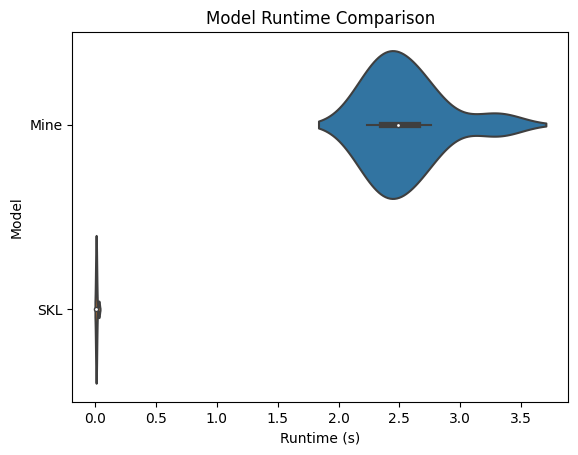

In [36]:
sns.violinplot(
    data = df_time,
    x = "time",
    y = "model",
    scale = "count"
)

plt.title("Model Runtime Comparison")
plt.xlabel("Runtime (s)")
plt.ylabel("Model")

plt.show()

The violin plot shows the distribution of the runtimes for each model. My implementation is much slower than Scikit-Learn's model and has much larger variance. This is because my implementation is using Newton's method. Newton's method had the highest accuracy of the BLR implementations, but it is the slowest.

## Deployment

As was previously mentioned, neither of these models is accurate enough to make useful predictions. However, if one of the models had to be deployed, then my model is the better choice. A deployed model would be running weekly at most, meaning that runtime is not important. Although the models had very similar accuracies, my implementation slightly outperformed Scikit-Learn's, making it the better choice for deployment.

# Mean Square Error Objective Function

## Newton's Method Implementation

Most BLR models use log likelihood as the objective function, but what would happen if mean square error (MSE) was used instead? To test this, we can modify the Newton's method BLR implementation to use MSE instead of log likelihood. To do this, we need to derive the new gradient and Hessian calculations. The MSE for a set of predicted values ($\hat{y}$) and the corresponding true values ($y$) is defined as the following:

$$MSE = \frac{1}{N} \sum_{i=1}^{N}(\hat{y}_{i} - y_{i}) ^ 2$$

To use Newton's method, we need to compute the gradient ($\nabla$) and the Hessian matrix ($H$).

$$\nabla = \frac{\partial (MSE)}{\partial w}$$

$$H_{ij} = \frac{\partial ^ 2 (MSE)}{\partial w_i \partial w_j}$$

$$\hat{y}_{i} = \sigma (w^T X_i), \sigma = sigmoid$$

$$\sigma' = \sigma (1 - \sigma)$$

$$\nabla = \frac{1}{N} \sum_{i=1}^{N} 2(\hat{y}_{i} - y_{i}) \cdot \sigma'(w^T X_i) \cdot X_i$$

$$H = \frac{1}{N} \sum_{i=1}^{N} 2 \sigma'(w^TX_i) \cdot (1 - \sigma`(w^TX_i)) \cdot X_iX_i^T$$

The regularization term is added to both the gradient and the hessian. The weight update function is the same as normal Newton's method, but we multiply the update by -1 because we want to minimize the MSE.

In [37]:
class HessianMSELogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        num_samples, num_features = X.shape
        # Compute sigmoid derivative
        g = self.predict_proba(X, add_bias = False).ravel()
        g_prime = g * (1 - g)
        # Compute hessian
        hessian = (X.T @ np.diag(2 * g_prime * (1 - g_prime)) @ X) / num_samples
        hessian += self._get_regularization(weights = False)
        # Compute gradient
        ydiff = y - g
        gradient = np.sum(X * 2 * ydiff[:,np.newaxis] * g_prime.reshape((len(g_prime), 1)), axis = 0) / num_samples
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self._get_regularization()
        
        return -1 * (pinv(hessian) @ gradient)

The new multiclass logistic regression function is almost identical to the original, but it is now compatible with the new MSE Newton's method solver.

In [38]:
class MyLogisticRegression2:
    def __init__(self, eta, iterations=20, solver="steepest", regularization="none", mixture=0.5, C=0.001):
        assert solver in ["steepest", "stochastic", "newton", "newton-mse"], "Invalid solver input"
        assert regularization in ["none", "l1", "l2", "both"], "Invalid regularization input"
        assert mixture >= 0 and mixture <= 1, "Invalid mixture"
        
        self.eta = eta
        self.iters = iterations
        self.opt = solver
        self.reg = regularization
        self.mix = mixture
        self.C = C
        
    def __str__(self):
        if(hasattr(self,'w_')):
            # is we have trained the object
            return 'Multiclass Logistic Regression Object with {} solver and {} regularization and coefficients:\n'.format(self.opt, self.reg) + str(self.w_) 
        else:
            return 'Untrained Multiclass Logistic Regression Object with {} solver and {} regularization'.format(self.opt, self.reg)
     
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        # Parameters to pass into binary classifier
        params = {
            "eta": self.eta,
            "iterations": self.iters,
            "regularization": self.reg,
            "mixture": self.mix,
            "C": self.C
        }
        # Set solver based on specified optimization method
        if self.opt == "steepest":
            self.solver = BinaryLogisticRegression
        elif self.opt == "stochastic":
            self.solver = StochasticLogisticRegression
        elif self.opt == "newton":
            self.solver = HessianLogisticRegression
        else:
            self.solver = HessianMSELogisticRegression
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = self.solver(**params)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    # Set specified hyperparameters after tuning (or manually)
    def set_hyperparameters(self, params):
        # Set parameters with defined hyperparameters
        if params["solver"] != None:
            assert params["solver"] in ["steepest", "stochastic", "newton", "newton-mse"], "Invalid solver input"
            self.opt = params["solver"]
        
        if params["regularization"] != None:
            assert params["regularization"] in ["none", "l1", "l2", "both"], "Invalid regularization input"
            self.reg = params["regularization"]
            
        if params["mixture"] != None:
            assert params["mixture"] >= 0 and params["mixture"] <= 1, "Invalid mixture"
            self.mix = params["mixture"]
            
        if params["penalty"] != None:
            self.C = params["penalty"]

## Fit Model

The properly test this MSE implementation of Newton's method, we need to tune the hyperparameters. We can use the same function as before to create a grid, but he solver will be newton-mse in all of the combinations. Since only 3/4 hyperparameters are being randomized, we do not need as many combinations to find the best hyperparameters.

In [39]:
grid_init2 = create_grid(50, seed = 7324, solver = "newton-mse")
grid_init2

,solver,regularization,mixture,penalty
0,newton-mse,both,0.316316,2.335721
1,newton-mse,l2,0.289289,0.000043
2,newton-mse,both,0.421421,0.000021
3,newton-mse,l1,0.520521,0.127427
4,newton-mse,l2,0.060060,0.263665
5,newton-mse,l2,0.194194,0.000379
6,newton-mse,both,0.305305,10.000000
7,newton-mse,both,0.918919,0.545559
8,newton-mse,l2,0.576577,0.000785
9,newton-mse,l2,0.696697,0.263665


In [40]:
%%time

params = {
    "eta": 0.1,
    "iterations": 20
}

grid_acc2 = tune(X, y, cv_object, grid_init2, params, MyLogisticRegression2)
grid_acc2

CPU times: user 1h 49min 23s, sys: 29min 49s, total: 2h 19min 12s
Wall time: 12min 35s


,solver,regularization,mixture,penalty,accuracy,time
34,newton-mse,l1,0.857858,4.832930,0.398723,1.647763
46,newton-mse,l1,0.945946,4.832930,0.398723,1.927185
29,newton-mse,l1,0.308308,0.545559,0.386064,1.098861
7,newton-mse,both,0.918919,0.545559,0.358191,1.052574
6,newton-mse,both,0.305305,10.000000,0.354362,1.122446
0,newton-mse,both,0.316316,2.335721,0.311596,2.859674
44,newton-mse,l1,0.626627,2.335721,0.309787,1.579960
35,newton-mse,l1,0.233233,1.128838,0.307766,2.067154
32,newton-mse,l1,0.419419,1.128838,0.307766,2.094085
4,newton-mse,l2,0.060060,0.263665,0.304149,1.078739


The MSE implementation of Newton's method has the best accuracy when using L1 regularizaition with a C of 2.3.

In [41]:
grid_acc2.groupby(["solver", "regularization"])[["accuracy", "time"]].describe()

accuracy                                          \
                             count      mean       std       min       25%   
solver     regularization                                                    
newton-mse both            11.0     0.274913  0.044271  0.244894  0.250479   
           l1              18.0     0.287707  0.053934  0.244574  0.251489   
           l2              13.0     0.272905  0.023438  0.250638  0.251064   
           none            8.0      0.251064  0.000000  0.251064  0.251064   

                                                         time            \
                                50%       75%       max count      mean   
solver     regularization                                                 
newton-mse both            0.251064  0.281702  0.358191  11.0  1.606652   
           l1              0.257766  0.307766  0.398723  18.0  1.624395   
           l2              0.255957  0.293830  0.304149  13.0  1.322288   
           none            0.251064  0.251064  0.251064  8.0   1.423198   

                                                                             \
                                std       min       25%       50%       75%   
solver     regularization                                                     
newton-mse both            0.569104  1.052574  1.158521  1.442097  1.939708   
           l1              0.443555  1.053907  1.123534  1.613861  2.072025   
           l2              0.389976  1.042530  1.099416  1.116947  1.465410   
           none            0.462118  1.053855  1.080150  1.134462  1.867971   

                                     
                                max  
solver     regularization            
newton-mse both            2.859674  
           l1              2.215947  
           l2              2.146125  
           none            2.097988

The table above shows the summary statistics for the accuracy and runtime of MSE models grouped by regularization method. Each distribution (except no regularization) shows that the mean accuracy is greater than the median accuracy. This suggests that the accuracy distributions are right skewed, and that certain values of C are significantly better than most others.

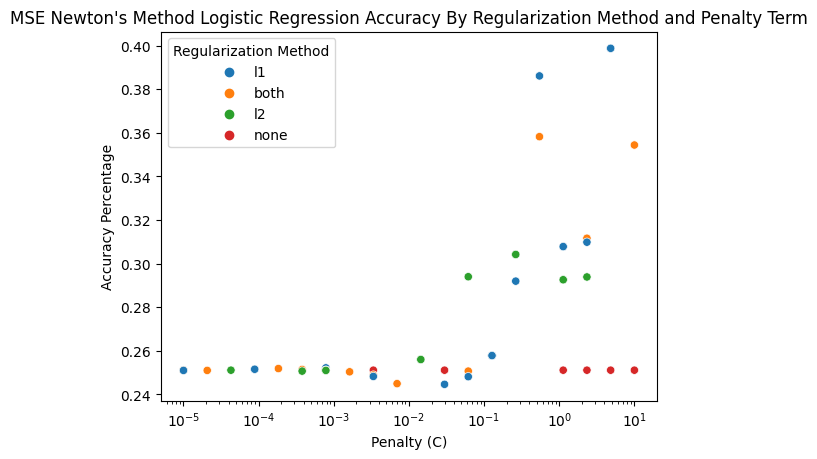

In [42]:
sns.scatterplot(
    data = grid_acc2, 
    x = "penalty", 
    y = "accuracy",
    hue = "regularization"
)

plt.title("MSE Newton's Method Logistic Regression Accuracy By Regularization Method and Penalty Term")
plt.xlabel("Penalty (C)")
plt.xscale("log")
plt.ylabel("Accuracy Percentage")
plt.legend(title = "Regularization Method")

plt.show()

The scatter plot shows that models with regularization and a large C value tend to have better accuracy than models without regularization or a small value of C. 

In [43]:
hyperparams = grid_acc2.to_dict("records")[0]

In [44]:
%%time

my_acc2 = []
my_yhats2 = []
my_times2 = []
conf_mat = None
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    my_model2 = MyLogisticRegression2(0.1)
    my_model2.set_hyperparameters(hyperparams)
    start = time.time()
    my_model2.fit(X[train_indices], y[train_indices])
    my_times2.append(time.time() - start)
    yhat = my_model2.predict(X[test_indices])
    my_yhats2.append(yhat)
    my_acc2.append(accuracy_score(y[test_indices], yhat))
    conf_mat = mt.confusion_matrix(y[test_indices], yhat)
print('Accuracy of: ', np.mean(my_acc2))

Accuracy of:  0.39872340425531916
CPU times: user 3min 6s, sys: 58.3 s, total: 4min 4s
Wall time: 23 s


In [45]:
print(my_model2)

conf_mat

Multiclass Logistic Regression Object with newton-mse solver and l1 regularization and coefficients:
[[-1.03291196e+07 -6.64966746e+07  5.97885964e+07  6.91648660e+07
   7.73441118e+06 -3.19599758e+07 -1.95716769e+07 -2.58780837e+07
   1.72044003e+07  5.17142020e+06  2.29948363e+07 -2.78229999e+07]
 [-5.39082914e+07 -4.09079847e+08  3.11817634e+08  3.70206203e+08
   2.52670796e+07 -2.09135705e+08 -3.87437322e+08  3.04917290e+08
   3.03604370e+08  4.80417372e+07 -1.48389177e+08 -1.55903971e+08]
 [ 5.10738860e+09  2.24339076e+11 -2.16542960e+11 -1.81417251e+11
  -1.19890319e+10  1.72310691e+11  2.17439573e+11 -2.25023975e+11
  -1.64913178e+11 -2.53287238e+10  1.57384439e+11  4.86339511e+10]]


array([[156,  36,  90],
       [136,  53,  70],
       [206,  47, 146]])

## Comparison to Log Likelihood

In [46]:
# Flatten the new yhats
my_yhats2 = [yhat for yhats in my_yhats2 for yhat in yhats]
# Create data frame to calculate accuracies
df_y2 = pd.DataFrame({
    "y": y_cv,
    "yhat": my_yhats2
}).groupby("y")
# Extract predictions
my_pred2 = df_y2["yhat"].value_counts()
# Calculate accuracy for the model and each result
my_pred_accs2 = []
for result in ["Win", "Draw", "Loss"]:
    my_pred_accs2.append(my_pred2[result, result] / sum(my_pred2[result]))
# Add total accuracy
my_pred_accs2.append(np.mean(my_acc2))

# Create data frame with accuracies by result and model
df_cmp2 = pd.DataFrame({
    "Result": ["Win", "Draw", "Loss", "Overall"] * 2,
    "Model": ["Log Likelihood"] * 4 + ["MSE"] * 4,
    "Accuracy": my_pred_accs + my_pred_accs2
})
df_cmp2

,Result,Model,Accuracy
0,Win,Log Likelihood,0.769136
1,Draw,Log Likelihood,0.155311
2,Loss,Log Likelihood,0.294656
3,Overall,Log Likelihood,0.458617
4,Win,MSE,0.404198
5,Draw,MSE,0.580586
6,Loss,MSE,0.200763
7,Overall,MSE,0.398723


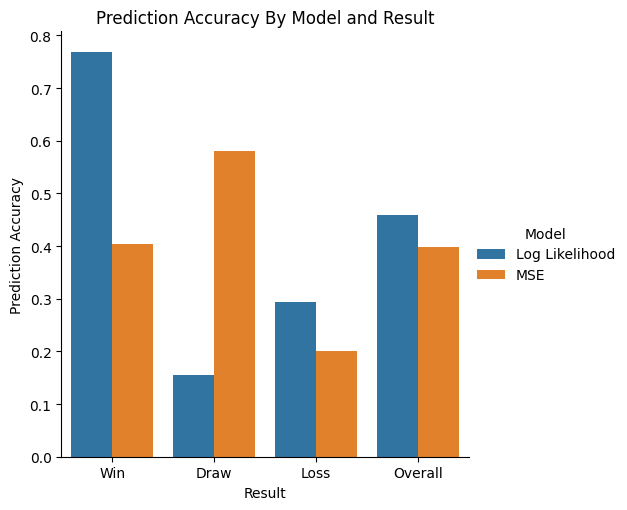

In [47]:
sns.catplot(
    data = df_cmp2,
    kind = "bar",
    x = "Result",
    y = "Accuracy",
    hue = "Model"
)

plt.title("Prediction Accuracy By Model and Result")
plt.xlabel("Result")
plt.ylabel("Prediction Accuracy")

plt.show()

The bar chart and the table above show how accurate each model is at predicting wins, draws, and losses. The MSE model is significantly better at predicting draws, but the log likelihood model is better at predicting wins and losses. This results in the log likelihood model having a better overall accuracy than the MSE model.

In [48]:
# Create data frame for timing data
df_time2 = pd.DataFrame({
    "model": ["Log Likelihood"] * 10 + ["MSE"] * 10,
    "time": my_times + my_times2
})

df_time2

,model,time
0,Log Likelihood,2.260408
1,Log Likelihood,2.391761
2,Log Likelihood,2.755799
3,Log Likelihood,2.346957
4,Log Likelihood,2.233817
5,Log Likelihood,3.305231
6,Log Likelihood,2.553064
7,Log Likelihood,2.431566
8,Log Likelihood,2.547075
9,Log Likelihood,2.688316


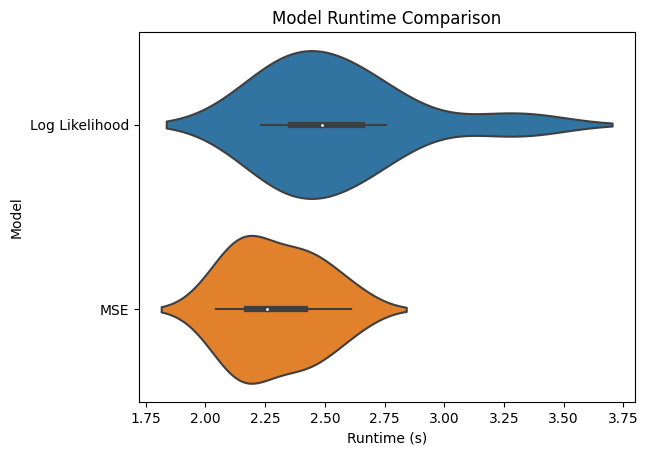

In [49]:
sns.violinplot(
    data = df_time2,
    x = "time",
    y = "model",
    scale = "count"
)

plt.title("Model Runtime Comparison")
plt.xlabel("Runtime (s)")
plt.ylabel("Model")

plt.show()

The violin plot above shows the distribution of the runtimes for the log likelihood and MSE models. Although the distributions have some overlap, the log likelihood model is on average faster than the MSE model.

In conclusion, the log likelihood implementation of Newton's method is faster and more accurate than the MSE implementation, making it the better choice.